## **🍹CGAN**

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, metrics, optimizers
from tensorflow.keras.datasets import mnist

def load_mnist_data():
    (X_train, y_train), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5  # 이미지를 [-1, 1] 범위로 정규화
    y_train = tf.keras.utils.to_categorical(y_train, 10)  # One-hot encoding
    return X_train, y_train

X_train, y_train = load_mnist_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
class Hyperparameters:
    def __init__(self):
        self.image_size = (28, 28, 1)
        self.classes = 10
        self.batch_size = 100
        self.z_dim = 100
        self.learning_rate = 0.0002
        self.adam_beta_1 = 0.5
        self.adam_beta_2 = 0.999
        self.epochs = 50
        self.critic_steps = 5
        self.gp_weight = 10.0

In [ ]:
def make_discriminator_model(input_shape=(28, 28, 1), num_classes=10):
    image = layers.Input(shape=input_shape)
    label = layers.Input(shape=(num_classes,))
    label_img = layers.Dense(input_shape[0]*input_shape[1], activation='linear')(label)
    label_img = layers.Reshape((input_shape[0], input_shape[1], 1))(label_img)
    x = layers.Concatenate()([image, label_img])
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    model = models.Model([image, label], x)
    model.summary()
    return model

In [ ]:
def make_generator_model(z_dim, num_classes=10):
    noise = layers.Input(shape=(z_dim,))
    label = layers.Input(shape=(num_classes,))
    x = layers.Concatenate()([noise, label])
    x = layers.Dense(7*7*256, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)
    model = models.Model([noise, label], x)
    model.summary()
    return model

In [ ]:
class ConditionalWGAN(models.Model):
    def __init__(self, generator, discriminator, latent_dim=100, critic_steps=5, gp_weight=10.0):
        super(ConditionalWGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight
        self.d_optimizer = optimizers.Adam(1e-4)
        self.g_optimizer = optimizers.Adam(1e-4)

    def compile(self):
        super(ConditionalWGAN, self).compile()
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        """Calculates the gradient penalty."""
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator([interpolated, labels], training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_images, labels = data
        batch_size = tf.shape(real_images)[0]

        for _ in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator([random_latent_vectors, labels], training=True)
                fake_logits = self.discriminator([fake_images, labels], training=True)
                real_logits = self.discriminator([real_images, labels], training=True)
                d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images, labels)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, labels], training=True)
            generated_logits = self.discriminator([generated_images, labels], training=True)
            g_loss = -tf.reduce_mean(generated_logits)

        g_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradient, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

Training From Now

In [ ]:
if not os.path.exists('output'):
    os.makedirs('output')

params = Hyperparameters()
generator = make_generator_model(params.z_dim)
discriminator = make_discriminator_model(params.image_size)
cgan = ConditionalWGAN(generator, discriminator, params.z_dim, params.critic_steps, params.gp_weight)
cgan.compile()

# Prepare the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(params.batch_size)

# Train the model
cgan.fit(train_dataset, epochs=params.epochs)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 110)            │              0 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 12544)          │      1,379,840 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 12544)          │         50,176 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 12544)          │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 7, 7, 256)      │              0 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 7, 7, 128)      │        819,200 │ reshape[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 7, 7, 128)      │            512 │ conv2d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 7, 7, 128)      │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 14, 14, 64)     │        204,800 │ leaky_re_lu_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 14, 14, 64)     │            256 │ conv2d_transpose_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 14, 14, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 28, 28, 1)      │          1,600 │ leaky_re_lu_2[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,456,384 (9.37 MB)

 Trainable params: 2,430,912 (9.27 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 784)            │          8,624 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 28, 28, 1)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 28, 28, 2)      │              0 │ input_layer_2[0][0],   │
│ (Concatenate)             │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 14, 14, 64)     │          3,264 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 14, 14, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 14, 14, 64)     │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 7, 7, 128)      │        204,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 7, 7, 128)      │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 7, 7, 128)      │              0 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6272)           │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │          6,273 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 223,089 (871.44 KB)

 Trainable params: 223,089 (871.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - d_loss: -9.5780 - g_loss: -16.5256
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - d_loss: -2.1446 - g_loss: -13.5326
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - d_loss: -1.9064 - g_loss: -3.0274
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - d_loss: -2.0921 - g_loss: 1.4227
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - d_loss: -1.9263 - g_loss: 1.6765
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - d_loss: -1.6808 - g_loss: -2.3554
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - d_loss: -1.5427 - g_loss: -6.4667
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - d_loss: -1.4039 - g_loss: -4.3597
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - d_loss: -1.2504 - g_loss: -8.4777
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - d_loss: -1.2564 - g_loss: -6.7268
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - d_loss: -1.2260 - g_loss: -9.9991 
Epoch 12/50
600/6

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 456ms/step


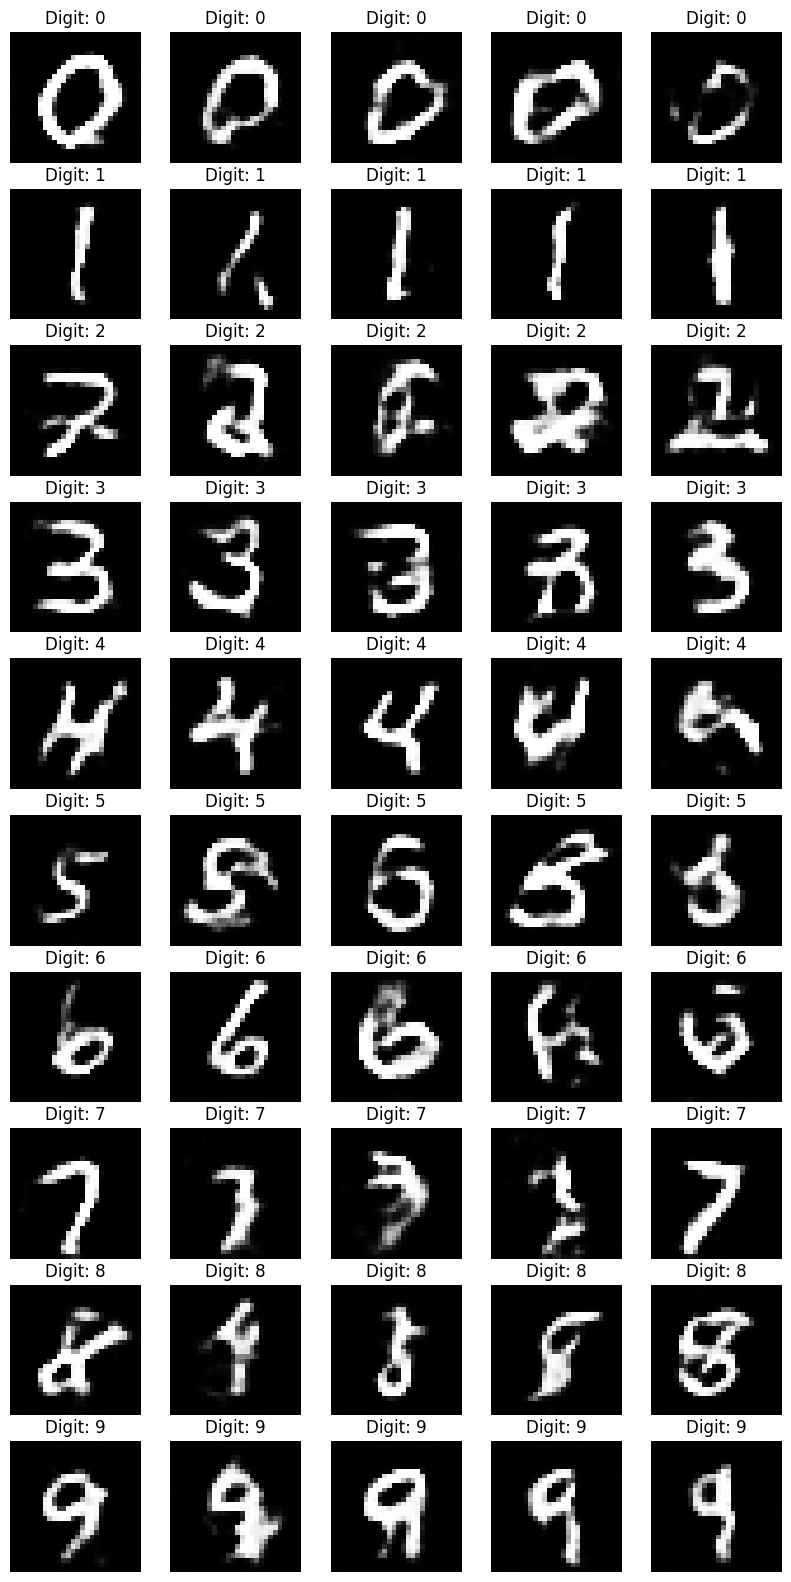

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
z_dim = 100  # 또는 Hyperparameters 클래스에서 정의된 값을 사용하세요.

# 그리드 차원 설정
image_grid_rows = 10
image_grid_columns = 5

# 랜덤한 잡음 샘플링
z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

# 생성할 이미지 레이블 준비 (0-9까지 각 숫자를 5번씩 생성)
labels_to_generate = np.array([i for i in range(10) for _ in range(5)])
labels_to_generate = tf.keras.utils.to_categorical(labels_to_generate, 10)  # 원-핫 인코딩

# 랜덤한 잡음에서 이미지 생성
gen_imgs = generator.predict([z, labels_to_generate])

# 이미지 픽셀 값 [0, 1] 사이로 스케일 변환
gen_imgs = 0.5 * gen_imgs + 0.5

# 이미지 그리드 설정 및 출력
fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 20), sharey=True, sharex=True)

cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f"Digit: {np.argmax(labels_to_generate[cnt])}")
        cnt += 1

plt.show()

In [ ]:
import tensorflow as tf

ckpt = tf.train.Checkpoint(generator=generator, discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(ckpt, directory='checkpoints', max_to_keep=5)

ckpt_manager.save()

'checkpoints/ckpt-1'

## **🍸Applying Unlearning - L2 Loss**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def apply_unlearning(generator, forget_samples, retain_samples, epochs=100, batch_size=100, alpha=10.0):
    optimizer = Adam(learning_rate=0.000005)
    latent_dim = 100

    for epoch in range(epochs):
        # Sample random noise
        noise_forget = np.random.normal(0, 1, (batch_size, latent_dim))
        noise_retain = np.random.normal(0, 1, (batch_size, latent_dim))

        # Generate random labels for forget and retain images within the valid range [0-9]
        labels_forget = np.random.randint(0, 10, batch_size)
        labels_retain = np.random.randint(0, 10, batch_size)

        # One-hot encode labels
        one_hot_labels_forget = tf.keras.utils.to_categorical(labels_forget, 10)
        one_hot_labels_retain = tf.keras.utils.to_categorical(labels_retain, 10)

        # Generate forget and retain images using the generator
        generated_forget_images = generator([noise_forget, one_hot_labels_forget], training=True)
        generated_retain_images = generator([noise_retain, one_hot_labels_retain], training=True)

        # Sample real forget and retain images
        real_forget_images = forget_samples[np.random.randint(0, forget_samples.shape[0], batch_size)]
        real_retain_images = retain_samples[np.random.randint(0, retain_samples.shape[0], batch_size)]

        with tf.GradientTape() as tape:
            # Calculate L2 loss for forget and retain images
            l2_loss_forget = tf.reduce_mean(tf.square(generated_forget_images - real_forget_images))
            l2_loss_retain = tf.reduce_mean(tf.square(generated_retain_images - real_retain_images))

            # Total loss includes the penalty for generating forget images
            total_loss = l2_loss_retain - alpha*l2_loss_forget

        # Calculate and apply gradients
        gradients = tape.gradient(total_loss, generator.trainable_variables)
        gradients_and_vars = [(g, v) for g, v in zip(gradients, generator.trainable_variables) if g is not None]

        # Apply valid gradients
        if gradients_and_vars:
            optimizer.apply_gradients(gradients_and_vars)
        else:
            print(f"No valid gradients at epoch {epoch}")

        # Log progress every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, L2 Loss Retain: {l2_loss_retain.numpy()}, '
                  f'L2 Loss Forget: {l2_loss_forget.numpy()}, Total Loss: {total_loss.numpy()}')


No valid gradients at epoch 0
Epoch 0, L2 Loss Retain: 0.5367425680160522, L2 Loss Forget: 0.5065280199050903, Total Loss: -4.528537273406982
No valid gradients at epoch 1
No valid gradients at epoch 2
No valid gradients at epoch 3
No valid gradients at epoch 4
No valid gradients at epoch 5
No valid gradients at epoch 6
No valid gradients at epoch 7
No valid gradients at epoch 8
No valid gradients at epoch 9
No valid gradients at epoch 10
Epoch 10, L2 Loss Retain: 0.5351718664169312, L2 Loss Forget: 0.5141720771789551, Total Loss: -4.60654878616333
No valid gradients at epoch 11
No valid gradients at epoch 12
No valid gradients at epoch 13
No valid gradients at epoch 14
No valid gradients at epoch 15
No valid gradients at epoch 16
No valid gradients at epoch 17
No valid gradients at epoch 18
No valid gradients at epoch 19
No valid gradients at epoch 20
Epoch 20, L2 Loss Retain: 0.5276373028755188, L2 Loss Forget: 0.4962330460548401, Total Loss: -4.434692859649658
No valid gradients at 

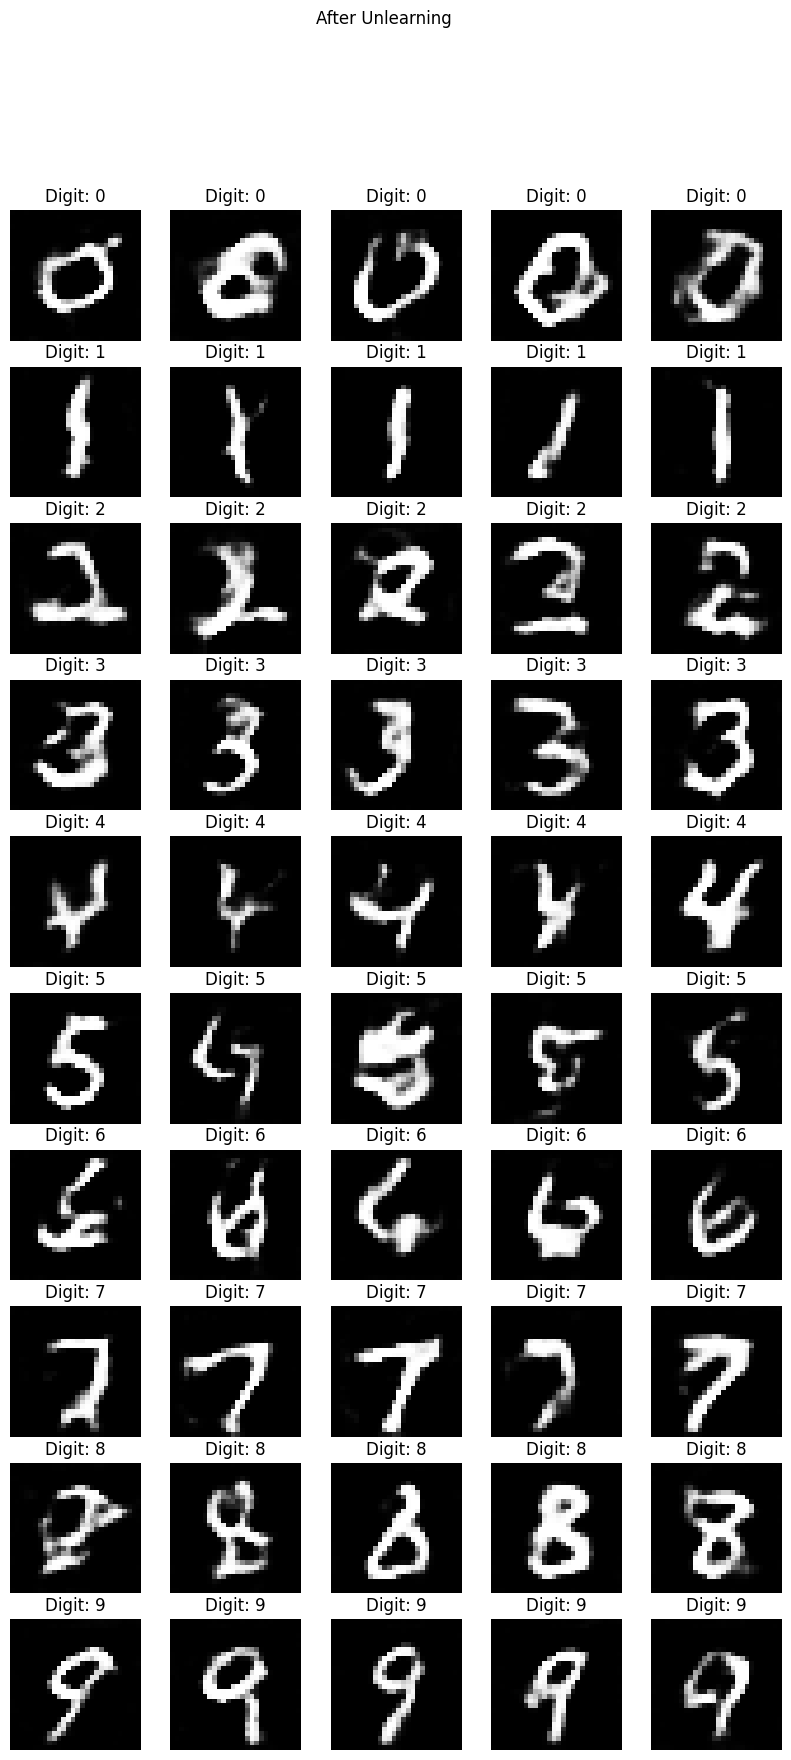

In [ ]:
ckpt.restore(tf.train.latest_checkpoint('checkpoints')).expect_partial()

# Forget and retain samples setup
forget_indices = np.where(np.isin(np.argmax(y_train, axis=1), [4]))[0]
retain_indices = np.where(np.isin(np.argmax(y_train, axis=1), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))[0]
forget_samples = X_train[forget_indices]
retain_samples = X_train[retain_indices]

# Apply unlearning
apply_unlearning(generator, forget_samples, retain_samples)

# Plot generated images after unlearning
def plot_generated_images(generator, title):
    z_dim = 100
    image_grid_rows = 10
    image_grid_columns = 5
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    labels_to_generate = np.array([i for i in range(10) for _ in range(5)])
    labels_to_generate = tf.keras.utils.to_categorical(labels_to_generate, 10)
    gen_imgs = generator.predict([z, labels_to_generate])
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 20), sharey=True, sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Digit: {np.argmax(labels_to_generate[cnt])}")
            cnt += 1

    plt.suptitle(title)
    plt.show()

print("After Unlearning")
plot_generated_images(generator, 'After Unlearning')

## **🍿Applying Unlearning - Margin**

In [ ]:
def apply_unlearning(generator, forget_samples, retain_samples, forget_labels, retain_labels, epochs=1000, batch_size=100, alpha=50.0):
  optimizer = Adam(learning_rate=5e-6)
  latent_dim = 100
  num_classes = 10

  forget_label = forget_labels[0]
  retain_label_set = np.unique(retain_labels)

  for epoch in range(epochs):
    # Sample random noise
    noise_forget = np.random.normal(0, 1, (batch_size, latent_dim))
    noise_retain = np.random.normal(0, 1, (batch_size, latent_dim))

    # Generate labels for forget and retain images
    labels_forget = np.full(batch_size, forget_label)  # 모두 잊으려는 레이블로 채움
    labels_retain = np.random.choice(retain_label_set, batch_size)  # retain_labels에서 무작위로 선택

    # One-hot encode labels
    one_hot_labels_forget = tf.keras.utils.to_categorical(labels_forget, num_classes)
    one_hot_labels_retain = tf.keras.utils.to_categorical(labels_retain, num_classes)

    # Generate images using the generator
    with tf.GradientTape() as tape:
      generated_forget_images = generator([noise_forget, one_hot_labels_forget], training=True)
      generated_retain_images = generator([noise_retain, one_hot_labels_retain], training=True)

      # Sample real images matching the generated labels
      indices_forget = [np.random.choice(np.where(forget_labels == label)[0]) for label in labels_forget]
      indices_retain = [np.random.choice(np.where(retain_labels == label)[0]) for label in labels_retain]
      real_forget_images = forget_samples[indices_forget]
      real_retain_images = retain_samples[indices_retain]

      # Contrastive loss
      margin = 1.0
      positive_loss = tf.reduce_mean(tf.square(generated_retain_images - real_retain_images))
      negative_loss = tf.reduce_mean(tf.maximum(0.0, margin - tf.square(generated_forget_images - real_forget_images)))
      total_loss = positive_loss + alpha * negative_loss

      # Calculate and apply gradients
      gradients = tape.gradient(total_loss, generator.trainable_variables)
      optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

      if epoch % 10 == 0:
        print(f'Epoch {epoch}, Positive Loss: {positive_loss.numpy()}, Negative Loss: {negative_loss.numpy()}, Total Loss: {total_loss.numpy()}')


Epoch 0, Positive Loss: 0.41769546270370483, Negative Loss: 0.8091374039649963, Total Loss: 40.87456512451172
Epoch 10, Positive Loss: 0.4191024601459503, Negative Loss: 0.819411039352417, Total Loss: 41.389652252197266
Epoch 20, Positive Loss: 0.452680379152298, Negative Loss: 0.8147528767585754, Total Loss: 41.19032287597656
Epoch 30, Positive Loss: 0.42375484108924866, Negative Loss: 0.8136531114578247, Total Loss: 41.10641098022461
Epoch 40, Positive Loss: 0.4439602494239807, Negative Loss: 0.8167819976806641, Total Loss: 41.28306198120117
Epoch 50, Positive Loss: 0.39642444252967834, Negative Loss: 0.8140987753868103, Total Loss: 41.10136032104492
Epoch 60, Positive Loss: 0.40975457429885864, Negative Loss: 0.810164213180542, Total Loss: 40.917964935302734
Epoch 70, Positive Loss: 0.42974525690078735, Negative Loss: 0.8128854036331177, Total Loss: 41.07401657104492
Epoch 80, Positive Loss: 0.41504552960395813, Negative Loss: 0.8118922114372253, Total Loss: 41.00965881347656
Epoch 

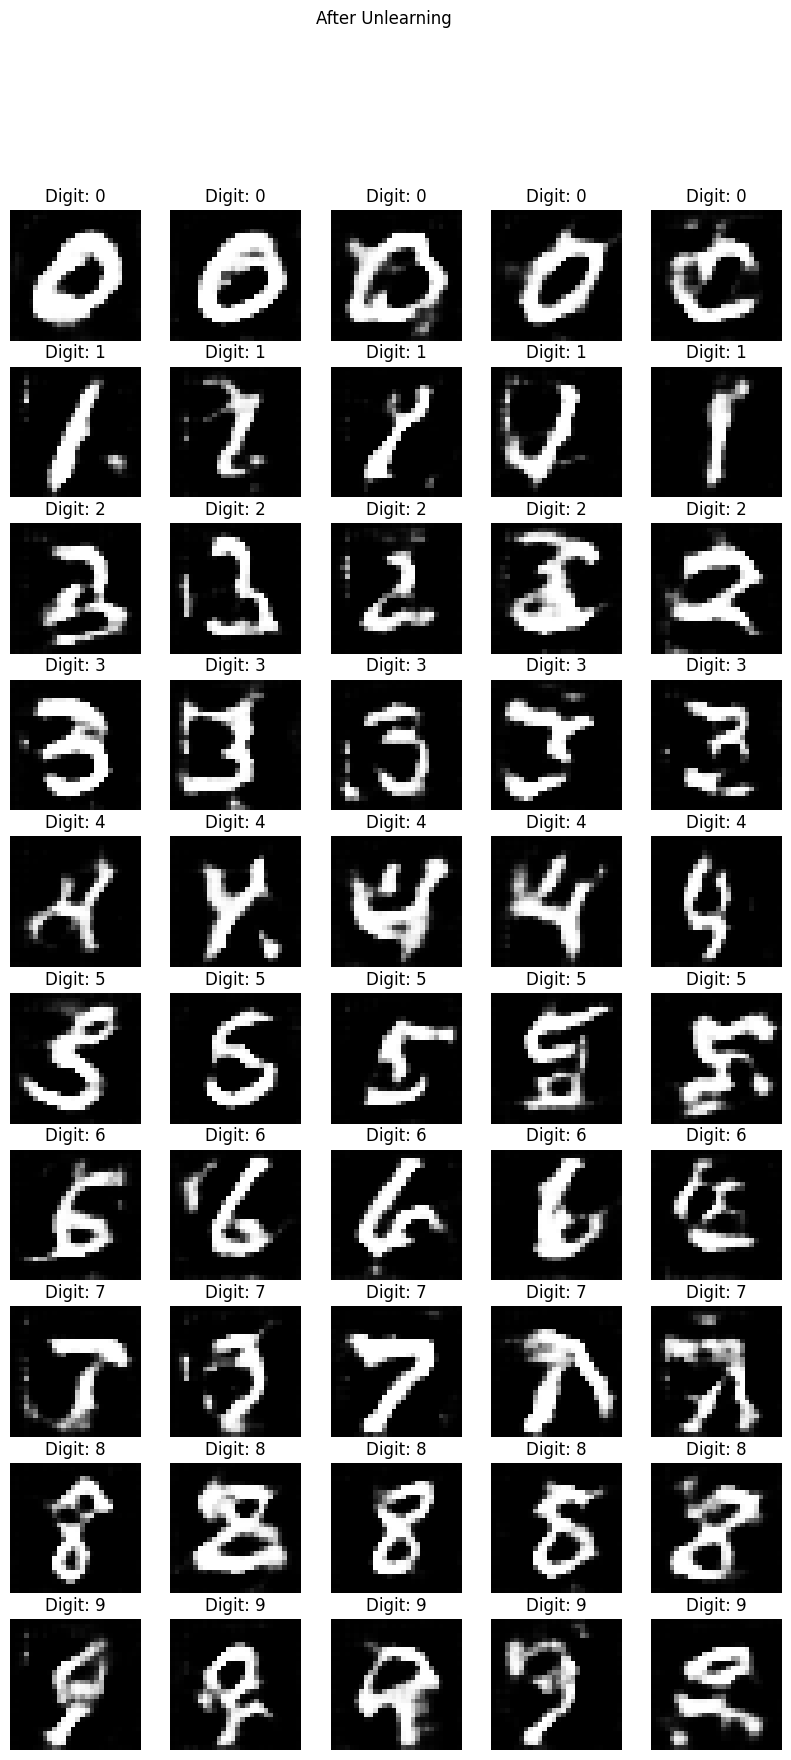

In [ ]:
ckpt.restore(tf.train.latest_checkpoint('checkpoints')).expect_partial()

forget_label = 4
all_labels = np.argmax(y_train, axis=1)

# Forget samples와 레이블
forget_indices = np.where(all_labels == forget_label)[0]
forget_samples = X_train[forget_indices]
forget_labels = all_labels[forget_indices]

# Retain samples와 레이블 (forget_label을 제외)
retain_indices = np.where(all_labels != forget_label)[0]
retain_samples = X_train[retain_indices]
retain_labels = all_labels[retain_indices]

apply_unlearning(generator, forget_samples, retain_samples, forget_labels, retain_labels)

def plot_generated_images(generator, title):
  z_dim = 100
  image_grid_rows = 10
  image_grid_columns = 5
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
  labels_to_generate = np.array([i for i in range(10) for _ in range(5)])
  labels_to_generate = tf.keras.utils.to_categorical(labels_to_generate, 10)
  gen_imgs = generator.predict([z, labels_to_generate])
  gen_imgs = 0.5 * gen_imgs + 0.5  # 이미지 스케일 조정
  fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(10, 20), sharey=True, sharex=True)

  cnt = 0
  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      axs[i, j].set_title(f"Digit: {np.argmax(labels_to_generate[cnt])}")
      cnt += 1

  plt.suptitle(title)
  plt.show()

plot_generated_images(generator, 'After Unlearning')
